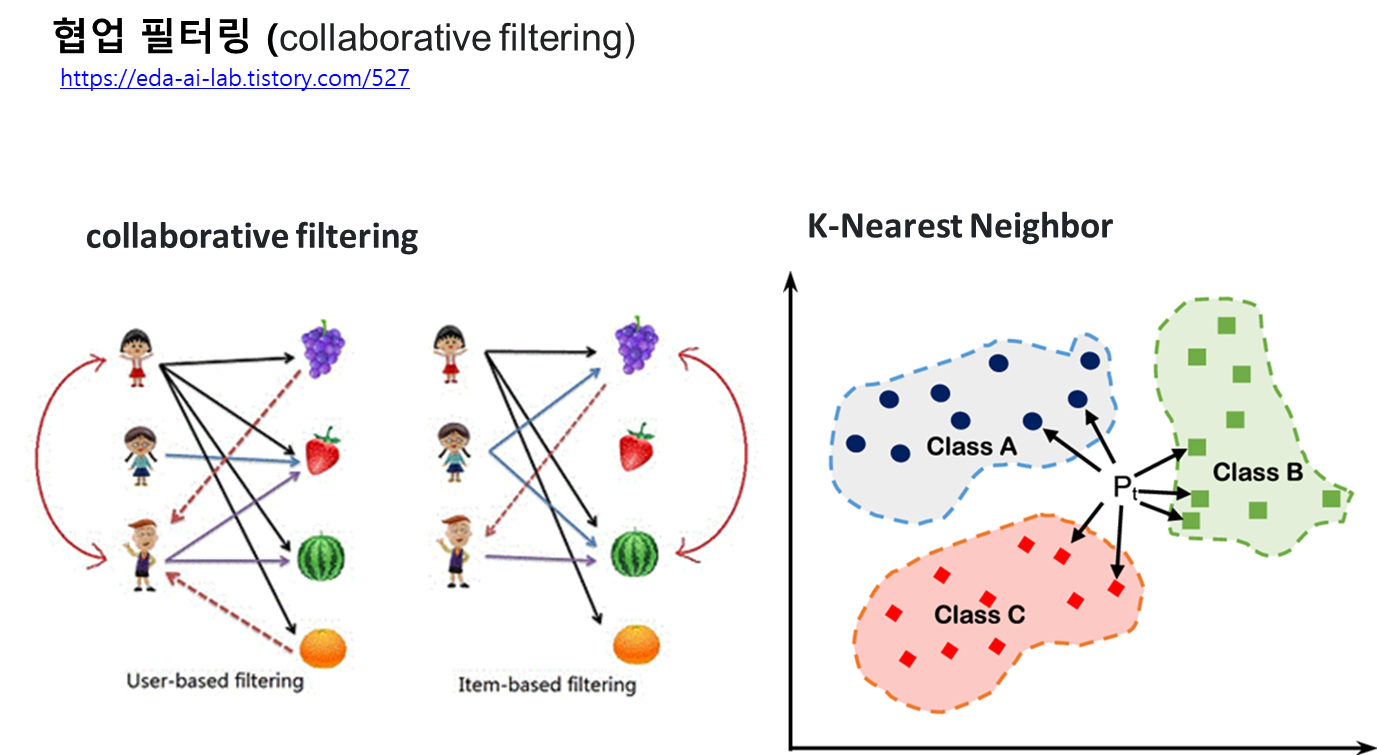

# **Matrix Factorization (SGD, ALS)**

https://developers.google.com/machine-learning/recommendation/collaborative/matrix


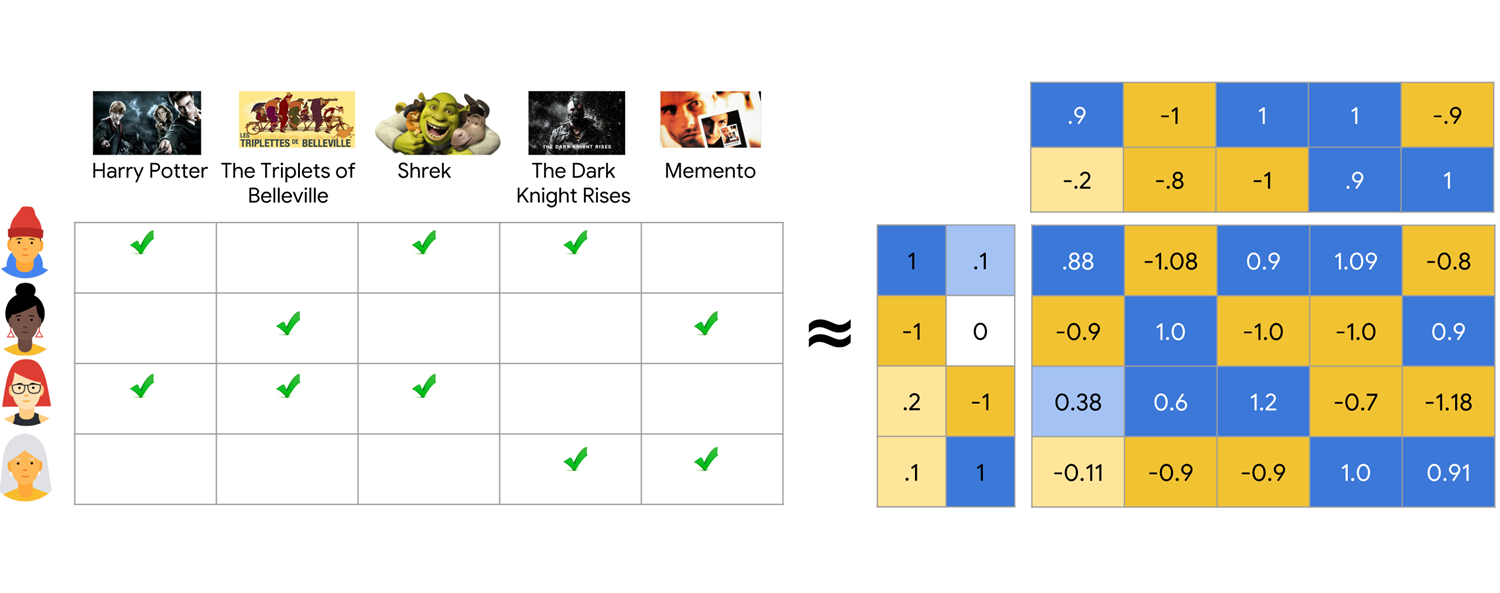

# **협업필터링을 활용한 행정동 – 연령/성별 분포 차이 분석**

## https://jumin.mois.go.kr/#

## 전체 읍면동별 연령대/성별 인구 분포 Matrix를 Neural Collaborative Filtering 로 분해하여 분석


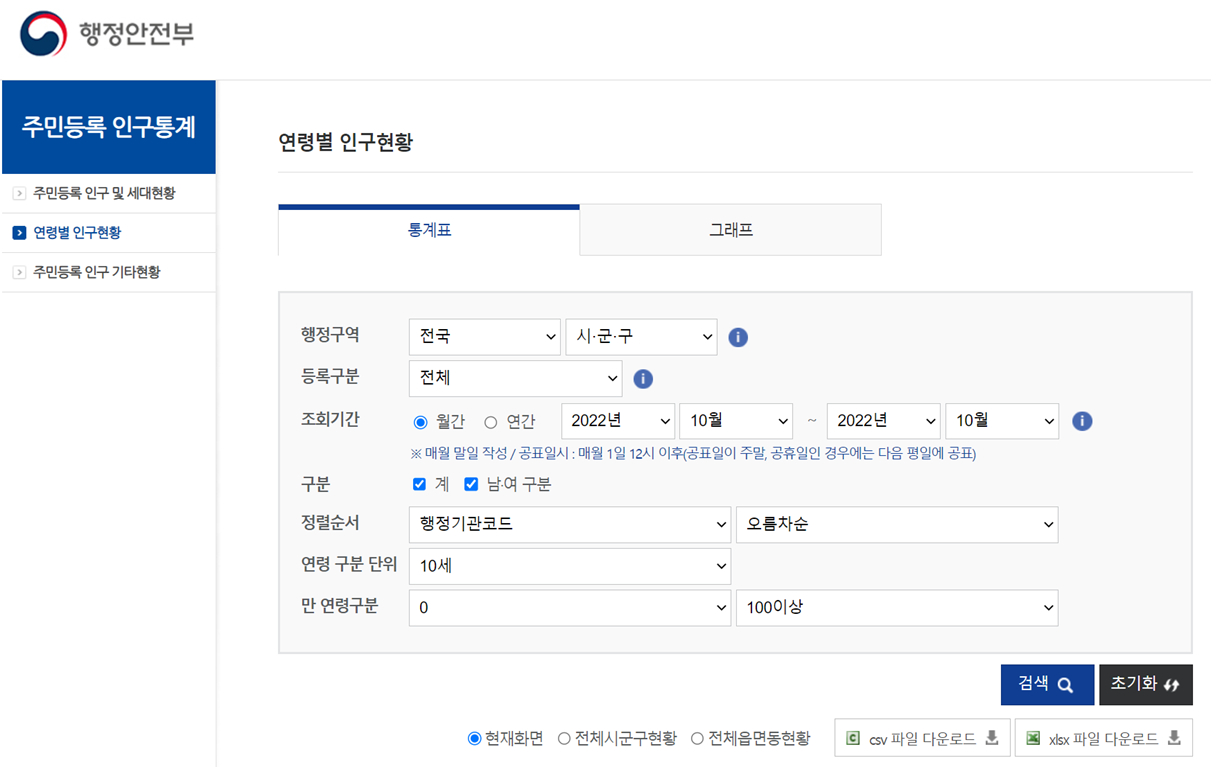

In [ ]:
!wget "https://hycms.hanyang.ac.kr/index.php?module=xn_media_content2013&act=dispXn_media_content2013DownloadContent&content_id=67429dc14119a" -O "data.csv"

In [ ]:
import numpy as np
import pandas as pd
import os, sys

import matplotlib.pyplot as plt


In [ ]:
data = pd.read_csv('data.csv', encoding='cp949', dtype=str)
data.head(5)

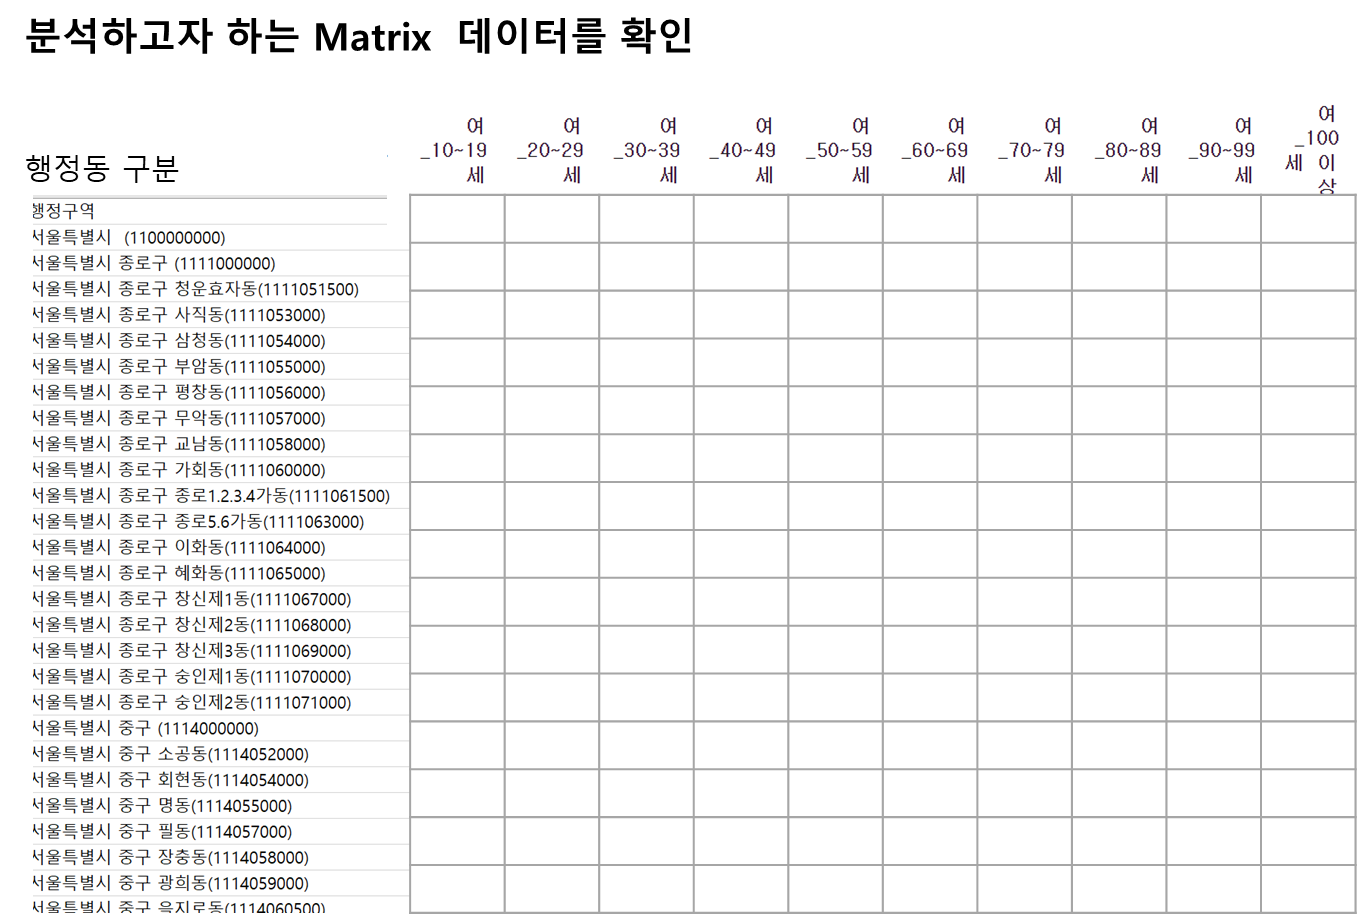

In [ ]:
# Remove rows where the '행정구역' field ends with '00000)'
data = data[~data['행정구역'].str.endswith('00000)')]

data.head(5)

In [ ]:
cols = np.array(data.columns)
np.append(cols[16:26], cols[29:])

In [ ]:
cols = np.array(data.columns)
cols = [col.replace('2024년10월_', '') for col in cols]
cols = [col.replace('남', 'M') for col in cols]
cols = [col.replace('여', 'F') for col in cols]
cols = [col.replace('세', '') for col in cols]
cols = [col.replace('이상', '~') for col in cols]
data.columns = cols

data = data[np.append(cols[16:26], cols[29:])]
cols = np.append(cols[16:26], cols[29:])
data.head(5)

In [ ]:
for col in cols:
  data[col] = data[col].str.replace(',', '').astype('int')

data.dtypes

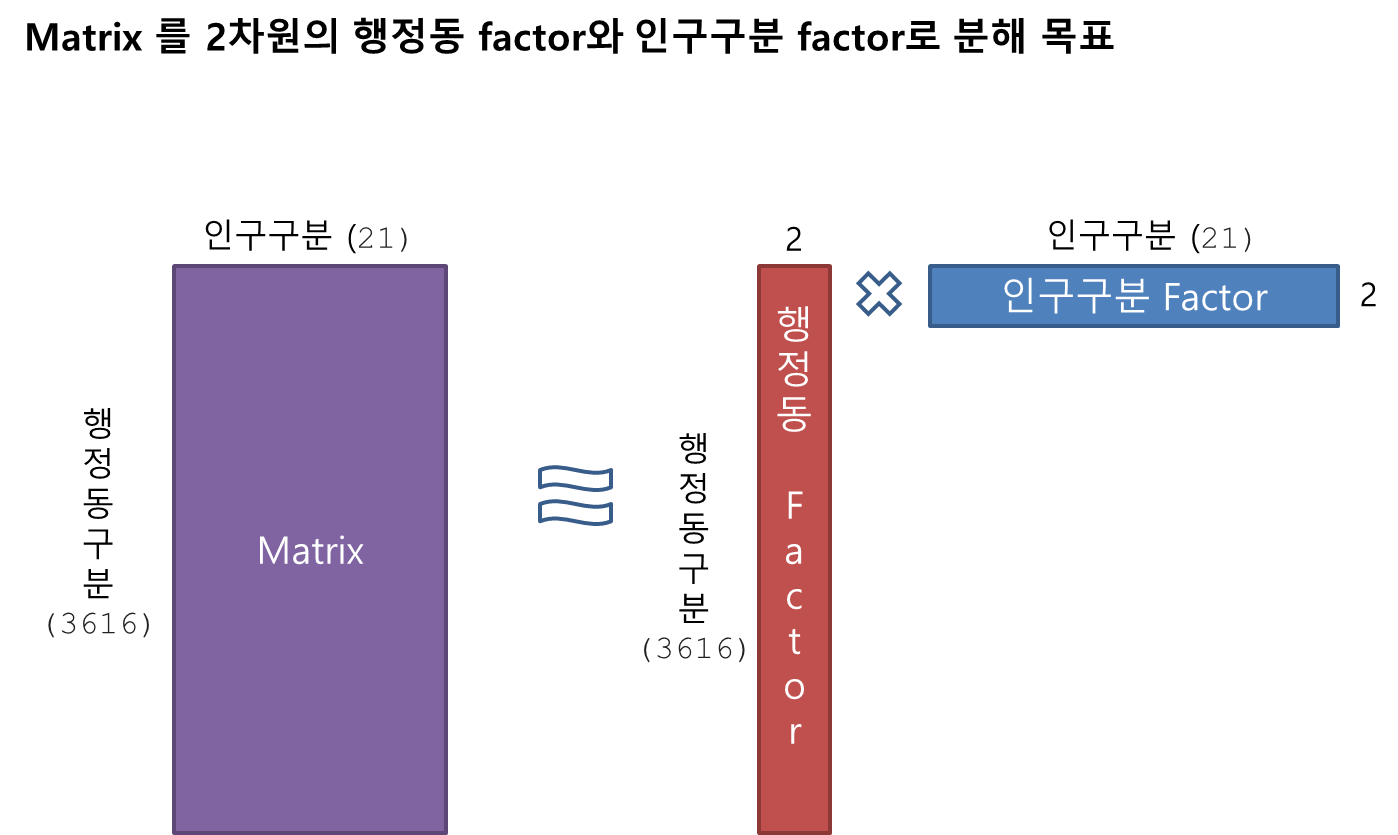

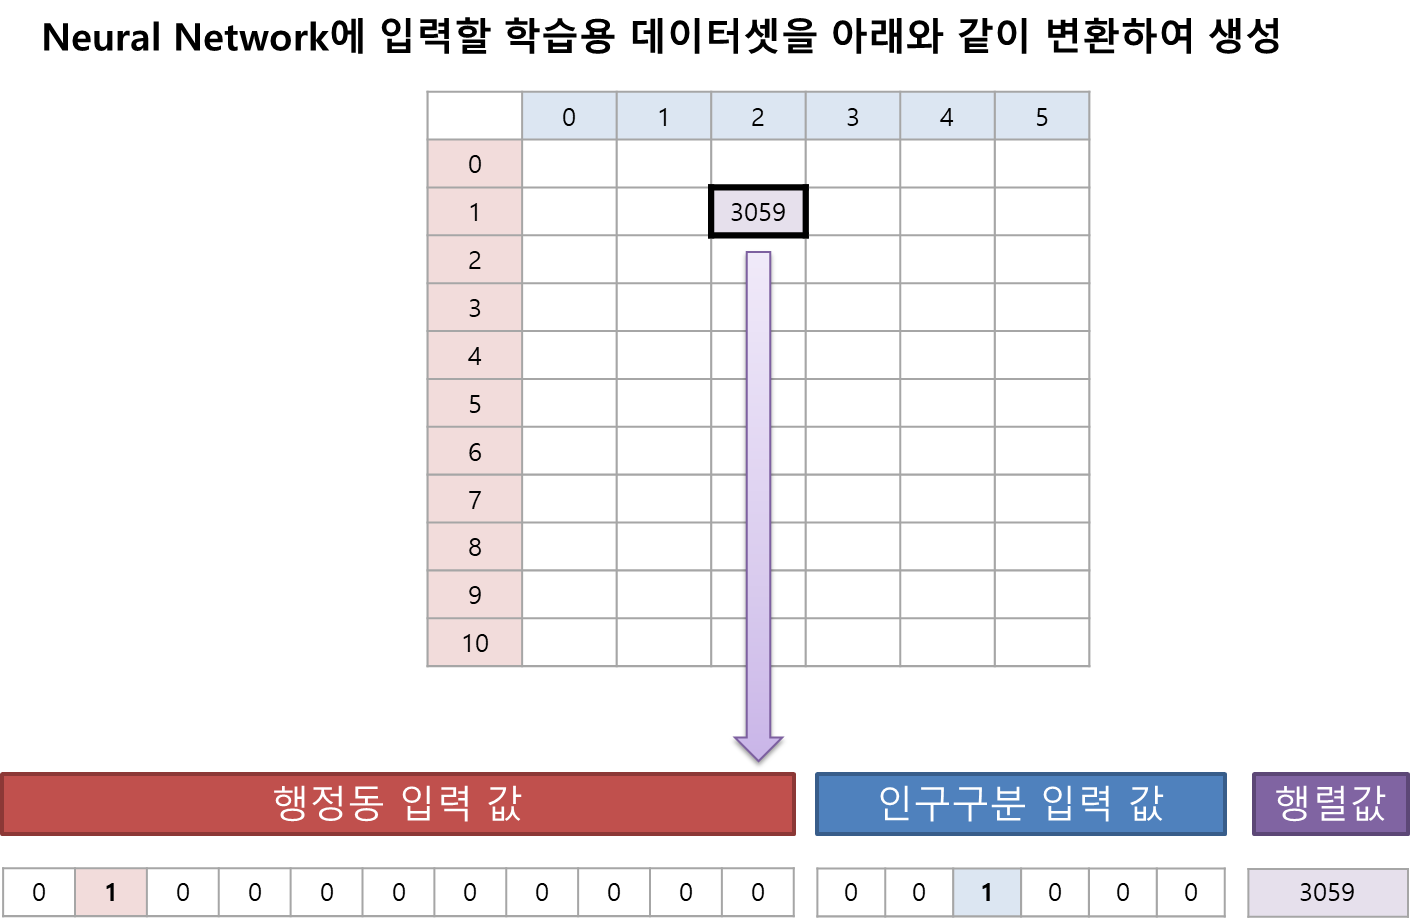

행정동과 연령대/성별 인구수로 구성된 테이블을 Factorizing하기 위해서

행정동 데이터 갯수와 연령대/성별 구분 갯수를 불러온다

In [ ]:

location = np.array(data.index)
pcount = np.array(data.columns)

print('location' + str(location.shape))
print('pcount' + str(pcount.shape))

학습용 데이터의 입력 변수를 행정동수+연령대/성별 수 크기이 배열을 만들고

대상 데이터만 1 값으로 표시하는 방식으로 데이터이 좌표를 표시할 목적으로 입력 행렬을 생성한다.


In [ ]:
input_data = np.concatenate([np.zeros(location.shape[0]), np.zeros(pcount.shape[0])])
input_data = input_data[:, np.newaxis]
input_data.shape

data 테이블을 칸단위로 이동하면서 학습용 데이터셋을 생성한다.

In [ ]:
#입력변수는 행정동수와 연령대/성별이 좌표 형태로 구성된다
#데이터 레코드는 data 행렬의 데이터 갯수 만큼 생성된다
#대상 데이터의 좌표만 1이 되고 나머지는 모두 0으로 처리
X1 = np.zeros([location.shape[0] * pcount.shape[0], location.shape[0], 1])
X2 = np.zeros([location.shape[0] * pcount.shape[0], pcount.shape[0], 1])

#대상 데이터 값을 지정한다.
y = np.zeros([location.shape[0] * pcount.shape[0], 1])
print('X1 = ' + str(X1.shape))
print('X2 = ' + str(X2.shape))
print('y = ' + str(y.shape))

n = 0
for i in range(location.shape[0]):
  for j in range(pcount.shape[0]):
    x1 = np.zeros([location.shape[0], 1])
    x2 = np.zeros([pcount.shape[0], 1])

    #행좌표(행정동) 위치 지정하기. (1로 변경)
    x1[i, 0] = 1
    #열좌표(연령대/성별) 위치 지정하기 (1로 변경)
    x2[j, 0] = 1

    X1[n, :, :] = x1
    X2[n, :, :] = x2

    y[n,0] = data.iloc[i,j]
    n+=1

y_max = y.max()
y = y / y_max

print('X1 좌표 = ' + str(np.where(X1[0, :, 0]==1)))
print('X2 좌표 = ' + str(np.where(X2[0, :, 0]==1)))
print('y 값 = ' + str(y[0,0]))

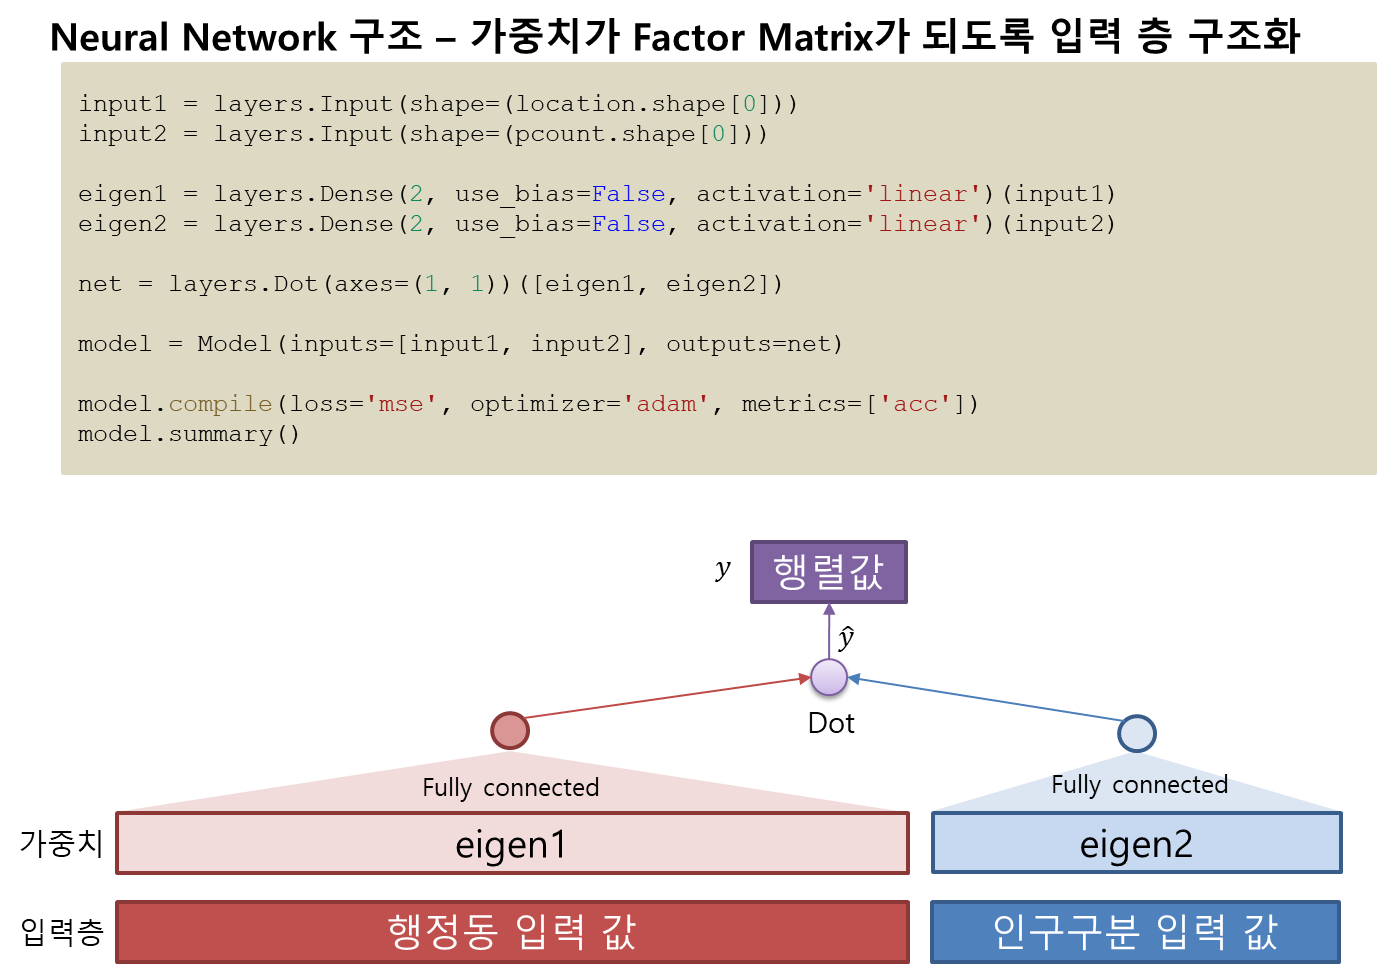

In [ ]:
import keras.layers as layers
import keras.optimizers as optimizers
from keras.models import Model, load_model
from keras import layers
from keras import models
from keras.models import load_model
input1 = layers.Input(shape=(location.shape[0],))
input2 = layers.Input(shape=(pcount.shape[0],))

eigen1 = layers.Dense(2, use_bias=False, activation='linear')(input1)
eigen2 = layers.Dense(2, use_bias=False, activation='linear')(input2)

net = layers.Dot(axes=(1, 1))([eigen1, eigen2])

model = Model(inputs=[input1, input2], outputs=net)

model.compile(loss='mse', optimizer='adam', metrics=['acc'])
model.summary()

In [ ]:
hist = model.fit(x=[X1, X2], y=y, epochs=10)

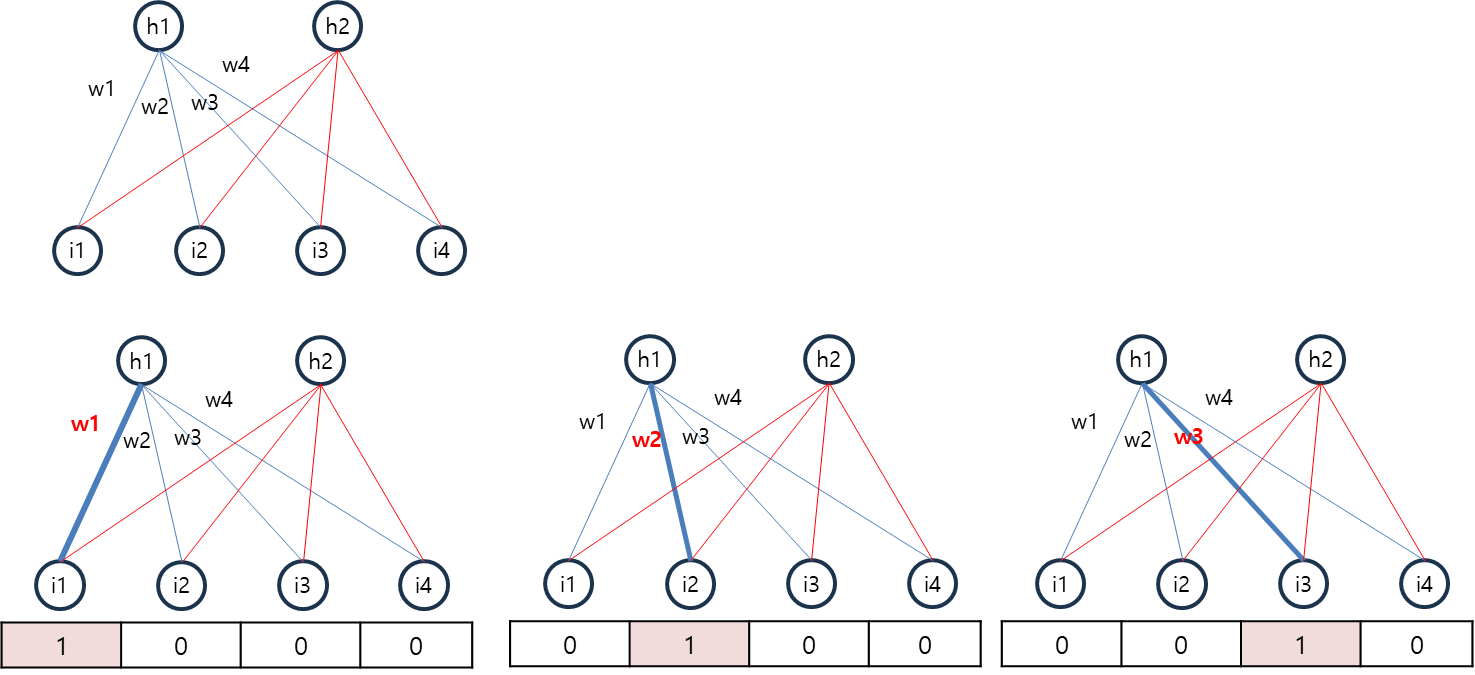

In [ ]:
location_eigen = np.array(model.layers[2].get_weights())
pcount_eigen = np.array(model.layers[3].get_weights())

print('location_eigen = ' + str(location_eigen.shape))
print('pcount_eigen = ' + str(pcount_eigen.shape))

In [ ]:
plt.scatter(location_eigen[0,:,0], location_eigen[0,:,1], color = 'r', s = 10)

plt.show()

In [ ]:

for i in range(pcount_eigen[0].shape[0]):
  if i < 10:
    plt.scatter(pcount_eigen[0,i,0], pcount_eigen[0,i,1], s = 20, marker='o', label=data.columns[i])
  else:
    plt.scatter(pcount_eigen[0,i,0], pcount_eigen[0,i,1], s = 20, marker='^', label=data.columns[i])

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside plot
plt.show()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cossim = cosine_similarity(location_eigen, location_eigen)

cossim.shape

In [ ]:

def display_cossim(cnum = 0, top=0.999) :
  print(location[cnum])
  data.loc[location[cnum]][:11].plot.bar(alpha=0.5, label='M', legend=True)
  data.loc[location[cnum]][11:].plot.bar(alpha=0.5, color='red', position=0, label='F', legend=True)
  plt.show()
  print()
  similarity = cossim[cnum,:].copy() #cos유사도 테이블 복사

  # Sort indices by similarity in descending order
  sorted_indices = np.argsort(similarity)[::-1]

  # Filter indices based on the threshold and select top 5
  top_indices = sorted_indices[np.where(similarity[sorted_indices] > top)]
  top_indices = top_indices[:5]  # Limit to top 5

  plt.figure(figsize=(20, 3))  # Adjust figure size based on the number of plots
  for i, index in enumerate(top_indices):
      plt.subplot(1, 5, i + 1) # Adjust subplot grid
      data.loc[location[index]][:11].plot.bar(alpha=0.5, label='M', legend=True)
      data.loc[location[index]][11:].plot.bar(alpha=0.5, color='red', position=0, label='F', legend=True)
      plt.title(f"Similarity: {similarity[index]:.4f}")


ipywidgets.interact(display_cossim, cnum=(0, data.shape[0], 1) , top=(0.999,1, 0.0001))

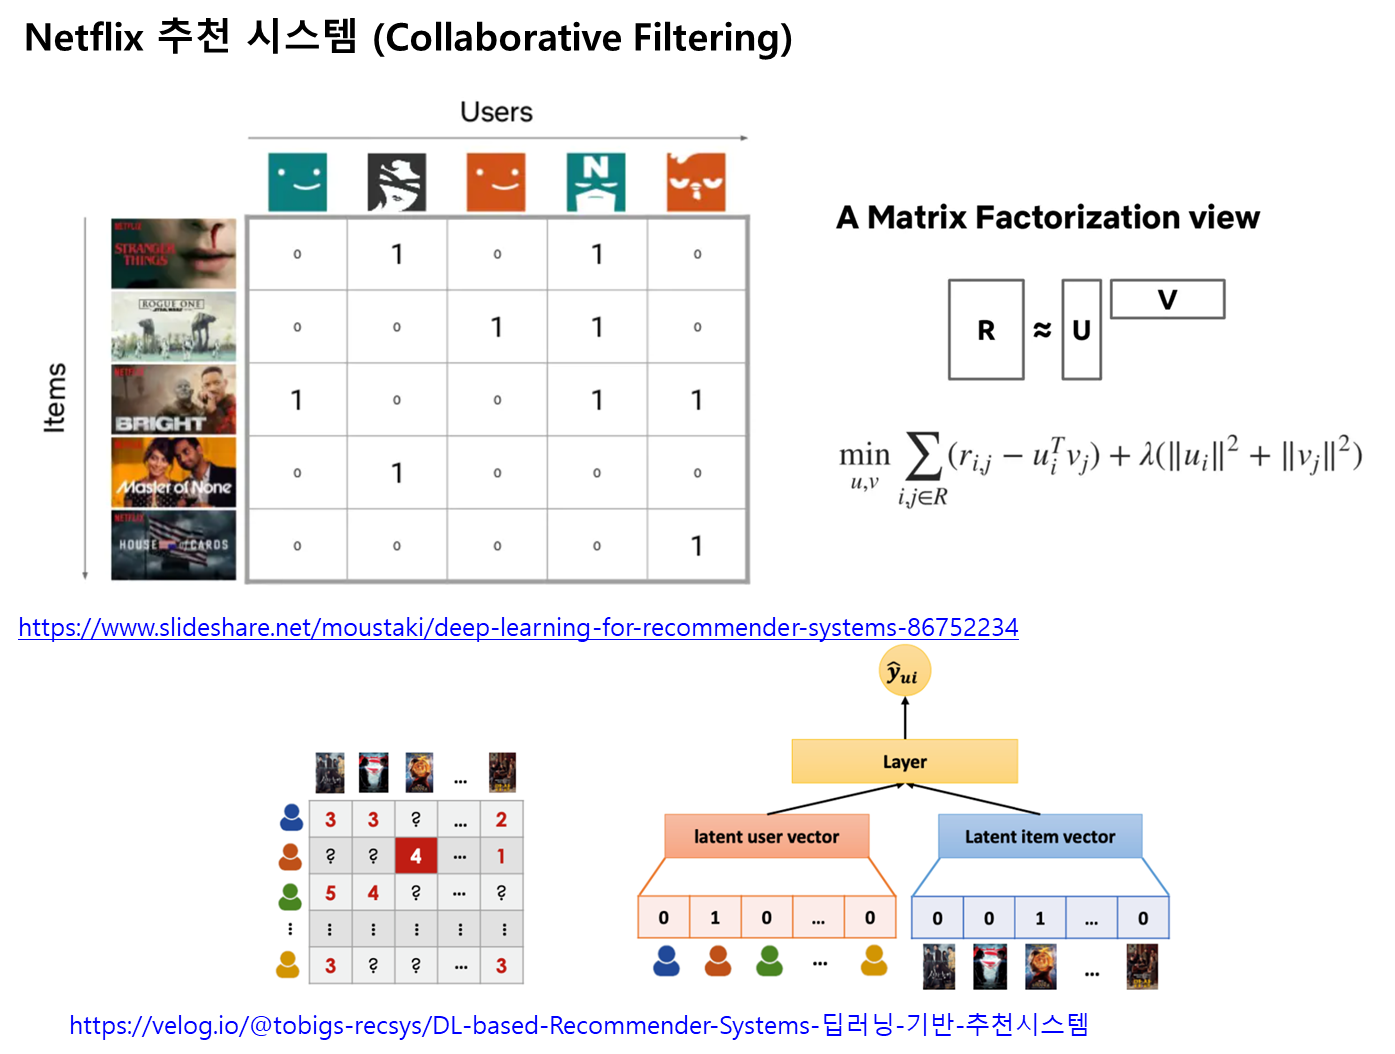

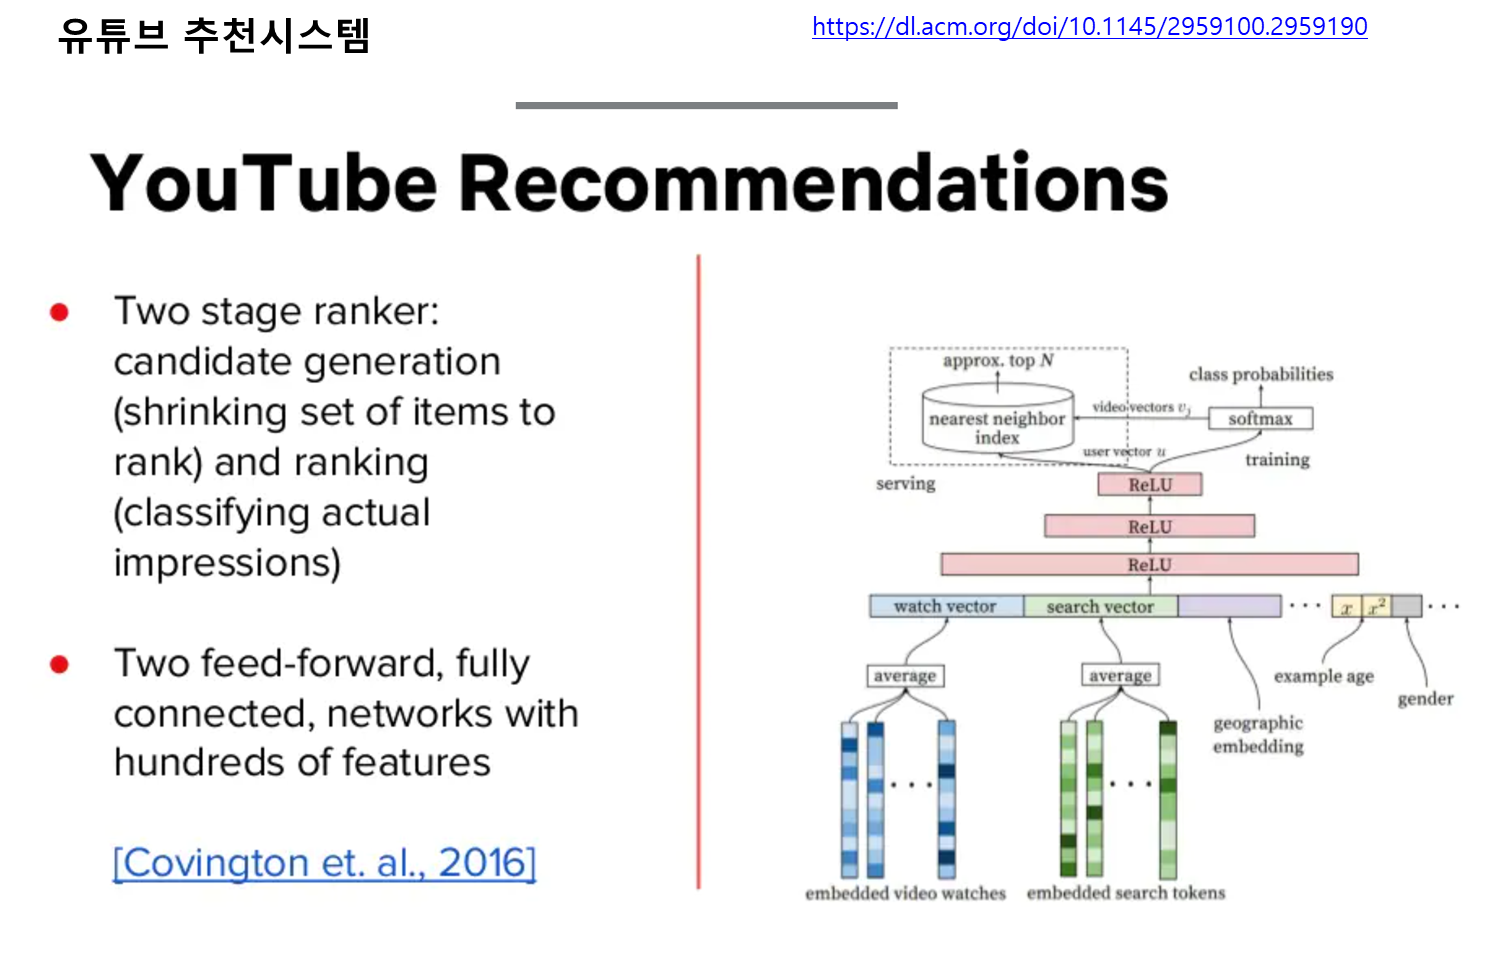

# **당근마켓 추천시스템**

https://medium.com/daangn/딥러닝-개인화-추천-1eda682c2e8c


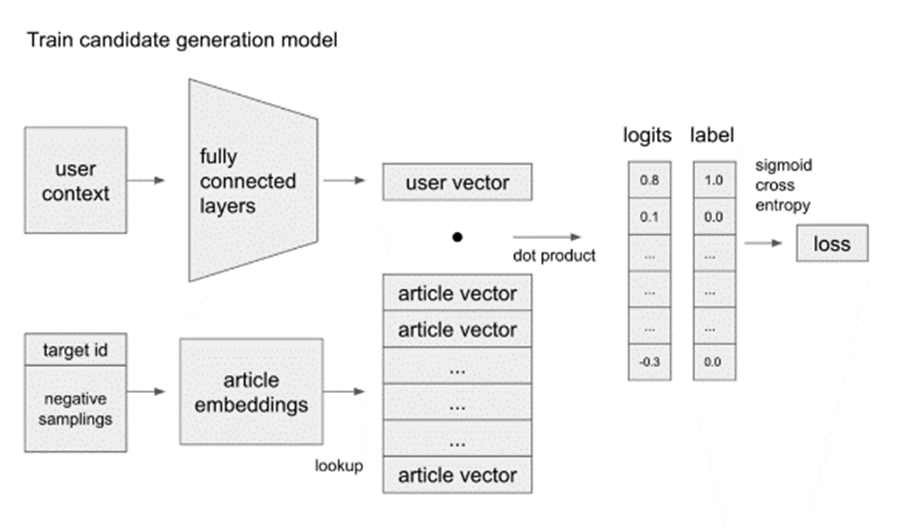

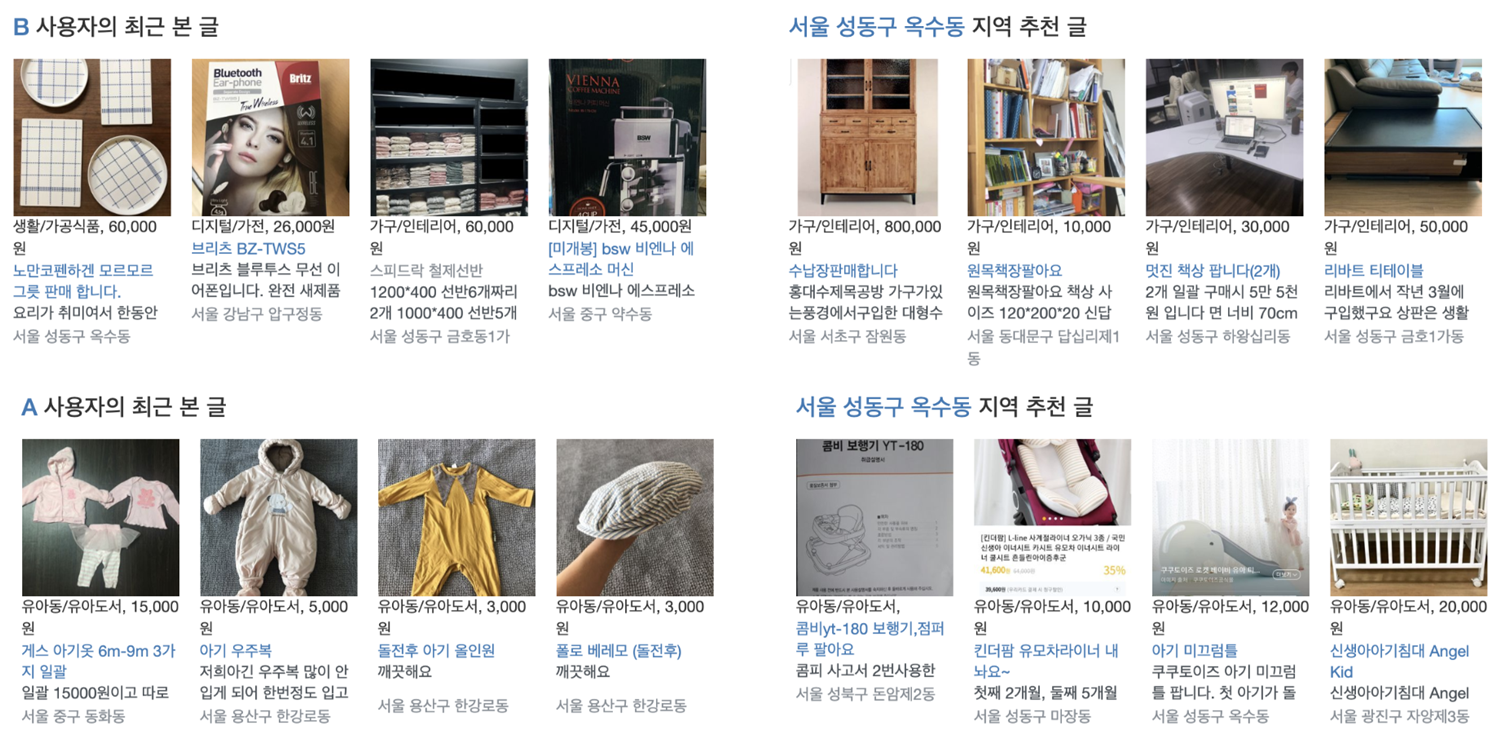